In [1]:
import ndex2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import igraph
import networkx as nx
from random import randint
from cyjupyter import Cytoscape
from timeit import default_timer as timer

import io
import requests
import pandas as pd

%matplotlib inline


## get test networks from NDEx in as edge tables in csv format

In [5]:
r = requests.get('https://test.ndexbio.org/v3/networks/d1258a93-c81c-11eb-9060-0660b7976219/export?type=edge')

df = pd.read_csv(io.StringIO(r.text),sep='\t')
edges = df[["source_id", "target_id"]]
edges

,source_id,target_id
0,7,1
1,16,17
2,16,1
3,17,1
4,18,16
...,...,...
141,56,30
142,1,56
143,59,61
144,61,58


### make a fresh gameboard
initialized to zeros
a square numpy array with area scaled to the sqrt of the node count

make a fresh cartesian coordinates aspect and assign random coordinates to the nodes
but no two nodes can have the same coordinates
check this by placing ones on the board

In [110]:
def repulsion_field(radius, scale=1, dtype=np.int32, center_spike=False):
    dimension = (2*radius)+1
    ef = np.zeros((dimension, dimension), dtype=dtype)
    energy = int(scale * radius)
    center_energy = 1000 if center_spike == True else energy
    for x in range(0, dimension):
        dx = abs(radius - x)
        for y in range(0, dimension):
            dy = abs(radius - y)
            distance = math.sqrt(dx**2 + dy**2)
            #energy = 1000 if distance == 0 else int(scale * (abs(distance - radius)**2))
            ef[x,y] = center_energy if distance == 0 else int(energy / distance**2)
    return ef

def attraction_field(radius, scale, dtype=np.int32):
    dimension = (2*radius)+1
    ef = np.zeros((dimension, dimension), dtype=dtype)
    energy = int(scale * radius)
    slope = energy/radius
    for x in range(0, dimension):
        dx = abs(radius - x)
        for y in range(0, dimension):
            dy = abs(radius - y)
            distance = math.sqrt(dx**2 + dy**2)
            ef[x,y] = -1 * energy if distance == 0 else min( 0, int((slope * distance) - energy))
    return ef

def show_field(field):
    sns.heatmap(field)
    plt.show()

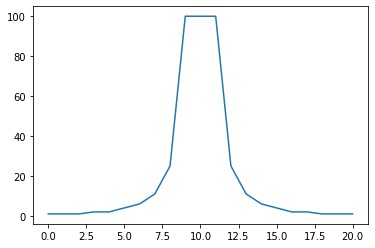

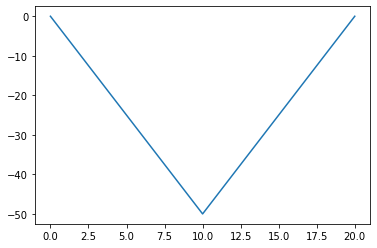

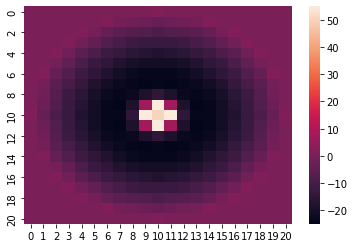

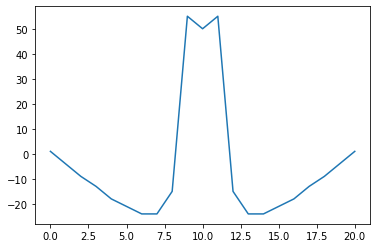

In [116]:
rf=repulsion_field(10, scale=10)
center_x = int(rf.shape[0]/2)
center_y = int(rf.shape[1]/2)
#rf[center_x, center_y] = 0
#show_field(rf)
plt.plot(rf[center_x])
plt.show()


af=attraction_field(10, scale=5)
#show_field(af)
center_x = int(af.shape[0]/2)
center_y = int(af.shape[1]/2)
plt.plot(af[center_x])
plt.show()

add_field(rf, af, center_x, center_y)
#af[center_x, center_y] = 0
show_field(af)
plt.plot(af[center_x])
plt.show()

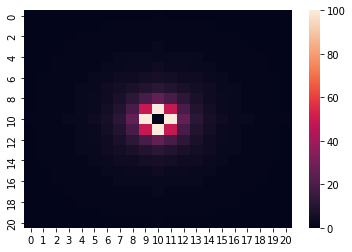

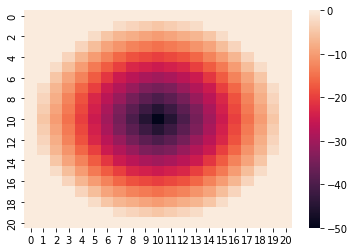

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  -2,  -3,  -4,  -5,  -4,  -3,
         -2,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  -2,  -5,  -7,  -8,  -9, -10,  -9,  -8,
         -7,  -5,  -2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  -3,  -6,  -9, -11, -13, -14, -15, -14, -13,
        -11,  -9,  -6,  -3,   0,   0,   0,   0],
       [  0,   0,   0,  -3,  -7, -10, -13, -16, -18, -19, -20, -19, -18,
        -16, -13, -10,  -7,  -3,   0,   0,   0],
       [  0,   0,  -2,  -6, -10, -14, -17, -20, -23, -24, -25, -24, -23,
        -20, -17, -14, -10,  -6,  -2,   0,   0],
       [  0,   0,  -5,  -9, -13, -17, -21, -25, -27, -29, -30, -29, -27,
        -25, -21, -17, -13,  -9,  -5,   0,   0],
       [  0,  -2,  -7, -11, -16, -20, -25, -28, -31, -34, -35, -34, -31,
        -28, -25, -20, -16, -11,  -7,  -2,   0],
       [  0,  -3,  -8, -

In [112]:
rf=repulsion_field(10, scale=10)
rf[10,10] = 0
show_field(rf)

af=attraction_field(10, scale=5)
show_field(af)
af

In [113]:
def make_gameboard (node_count, sparsity=30, dtype=np.int32):
    radius = round(math.sqrt(node_count * sparsity))
    return energy_field(radius, scale=2, dtype=dtype)
    #return np.zeros((dimension, dimension), dtype=dtype)

def make_coords_from_edge_array(edge_array, sparsity=30, dtype=np.int64):
    # for each edge, add the nodes to coords, updating the adjancy set
    coords = {}
    for edge in edge_array:
        # print(edge[0], " ", edge[1])
        if edge[0] not in coords:
            coords[edge[0]] = {"adj":set()}
        coords[edge[0]]["adj"].add(edge[1])
        if edge[1] not in coords:
            coords[edge[1]] = {"adj":set()}
        coords[edge[1]]["adj"].add(edge[0])
            

    gameboard = make_gameboard(len(coords), sparsity=sparsity, dtype=dtype)
    dimension = gameboard.shape[0]
    temp_board = np.zeros((dimension, dimension))
    center_left = round(dimension/4)
    center_right = dimension - center_left
    
    # randomly place the nodes in the center of the board
    for node_id, node in coords.items():
        placed = False
        while not placed:
            x = randint(center_left, center_right)
            y = randint(center_left, center_right)
            if temp_board[x, y] == 0:
                temp_board[x, y] = 1
                placed = True
        node["x"] = x
        node["y"] = y

    return coords, gameboard       

def make_coords_from_cx (cx_network, sparsity=30):
    dimension = gameboard.shape[0]
    coords = {}
    nodes = cx_network.get_nodes()
    for node_id, node in nodes:
        #print(node)
        placed = False
        while not placed:
            x = randint(0,dimension-1)
            y = randint(0,dimension-1)
            if gameboard[x, y] == 0:
                gameboard[x, y] = 1
                placed = True
        coords[node_id]= {
            'x' : x,
            'y' : y,
            'adj' : set()
       }
    for edge_id, edge in cx_network.get_edges():
        #print(edge)
        coords[edge["s"]]['adj'].add(edge['t'])
        coords[edge["t"]]['adj'].add(edge['s'])
    return coords, gameboard

def igraph_layout_from_coords(g, coords):
    igraph_layout = [(0,0)] * len(coords)
    print(len(g.vs), len(coords))

    for node_id, node in coords.items():
        igraph_node_id = g.vs.find(cx_id=node_id).index
        igraph_layout[igraph_node_id] = (node["x"],node["y"])
    # print(igraph_layout)
    return igraph.Layout(igraph_layout)

def draw_igraph_with_coords(g, coords):
    l = igraph_layout_from_coords(g, coords)
    fig, ax = plt.subplots()
    igraph.plot(g, layout=l, target=ax)
    #igraph.plot(g, l)
    
def cx_layout_from_coords(coords, node_dimension = 40):
    cx_layout = []
    for node_id, node in coords.items():
        cx_node = {"node": node_id,
                   "x": node["x"] * node_dimension,
                   "y": node["y"] * node_dimension}
        cx_layout.append(cx_node)
    return cx_layout

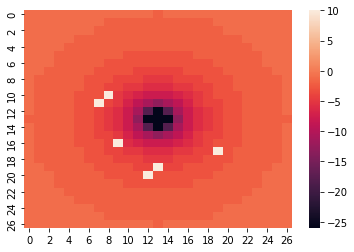

In [98]:
test_edges = [
    ["foo", "bar"], 
    ["foo", "baz"],
    ["bar", "baz"],
    ["foo", "fred"],
    ["fred", "jane"],
    ["fred", "alice"]
]

test_c, test_gb = make_coords_from_edge_array(test_edges)
for node_id, node in test_c.items():
    test_gb[node["x"], node["y"]]=10

show_field(test_gb)

In [119]:
def add_field(r_field, g_field, x, y, remove=False, show_coords=False):
    if show_coords: print("coords", x,y)
    gx_max = g_field.shape[0] - 1
    gy_max = g_field.shape[1] - 1
    rx_max = r_field.shape[0] - 1
    ry_max = r_field.shape[1] - 1
    #
    #   0.0 1.0 2.0
    #   0.1 1.1 2.1
    #   0.2 1.2 2.2
    #
    x_offset = int(r_field.shape[0]/2)
    y_offset = int(r_field.shape[1]/2)
    #print("gb shape", g_field.shape)
    #print("rf offset", x_offset, y_offset)
    gtx = x - x_offset
    gty = y - y_offset
    gbx = x + x_offset
    gby = y + y_offset
    #print("gb target", gtx,gty,gbx,gby)
    rtx = 0
    rty = 0
    rbx = rx_max
    rby = ry_max
    #print("rf source", rtx,rty,rbx,rby)
    # trim if r_field goes off board negative
    if gtx < 0:
        #print("negative x")
        rtx = -gtx
        gtx = 0        
    if gty < 0:
        #print("negative y")
        rty = -gty
        gty = 0
    # trim if r_field goes off board positive
    if gbx > gx_max:
        dx = gbx - gx_max
        #print("positive x", dx)
        gbx = gx_max
        rbx = rx_max - dx
    if gby > gy_max:
        dy = gby - gy_max
        #print("positive y", dy)
        gby = gy_max
        rby = ry_max - dy
    #print("adj gb target", gtx,gty,gbx,gby) 
    #print("adj rf source", rtx,rty,rbx,rby)
    #gameboard[gtx, gty] = 1
    #gameboard[gbx, gby] = 1
    # add the r_field to the g_field
    #print(g_field[gtx:gbx+1, gty:gby+1])
    #print(r_field[rtx:rbx+1, rty:rby+1])
    if remove:
        g_field[gtx:gbx+1, gty:gby+1] -= r_field[rtx:rbx+1, rty:rby+1]
    else:
        g_field[gtx:gbx+1, gty:gby+1] += r_field[rtx:rbx+1, rty:rby+1]

# wrapper for readability
def subtract_field(r_field, g_field, x, y, show_coords=False):
    add_field(r_field, g_field, x, y, remove=True, show_coords=show_coords)
    
def test_add_field_positions(small_size=21, large_size=101, dtype=np.int64):
    
    # large target, small source
    test_add_field_overlaps(small_size, large_size)
    # small target, large source
    test_add_field_overlaps(large_size,small_size)
    
def test_add_field(source_size, target_size, pos="center", dtype=np.int64):
    source = np.ones((source_size, source_size), dtype=dtype) 
    target = np.ones((target_size, target_size), dtype=dtype) 
    target_max_x = target.shape[0]-1
    target_max_y = target.shape[1]-1
    target_center_x = int(target.shape[0]/2)
    target_center_y = int(target.shape[1]/2)
    print(source.shape, target.shape, " ", pos)
    if pos=="top_left":
        add_field(source, target, 0,0)
    elif pos=="bottom_right":      
        add_field(source, target, target_max_x, target_max_y)
    elif pos=="center":
        add_field(source, target, target_center_x, target_center_y)   
    show_field(target)
    
def test_add_field_overlaps(source_size, target_size):
    test_add_field(source_size, target_size, pos="top_left")
    test_add_field(source_size, target_size, pos="bottom_right")
    test_add_field(source_size, target_size, pos="center")

def test_add_field_speed(target_size,  source_size, rounds=1000, target_x=5, target_y=5, dtype=np.int64):
    target_field = np.ones((target_size, target_size), dtype=dtype)
    source_field = np.ones((source_size, target_size), dtype=dtype)
    start = timer()
    for i in range(0, rounds):
        add_field(source_field, target_field, target_x, target_y)
    end = timer()
    elapsed_time = end - start
    rate = elapsed_time / rounds
    print("elapsed time = ", elapsed_time , " rate = ", rate)
    
        
def layout_node_step(gb, s_field, r_field, a_field, node, coords):
    # make a scratchpad board where we add all the attraction fields
    # and the use it to select the destination and update the repulsion board
    s_field[...]=0
    for adj_node_id in node['adj']:
        # add an attraction field for each, to the scratchpad field
        adj_node = coords[adj_node_id]
        add_field(a_field, s_field, adj_node["x"], adj_node["y"])
    
    # add s_field to the gameboard
    gb += s_field
    # remove the node from the repulsion board
    # subtract it at it's current location
    subtract_field(r_field, gb, node['x'], node['y'])
    
    # select the destination
    # idea #1: choose a location with the minimum value
    # argmin returns the index of the first location containing the minimum value in a flattened 
    # version of the array
    # unravel_index turns the index back into the coordinates
    destination = np.unravel_index(np.argmin(gb, axis=None), s_field.shape)
    #print(node)
    #print("destination: ", destination)

    # add it at the destination
    add_field(r_field, gb, destination[0], destination[1])
    
    # subtract the s_field
    gb -= s_field
    # update the node's coordinates
    node["x"] = destination[0]
    node["y"] = destination[1] 
          
def layout_network(cx_network, rounds=1, sparsity=30, repulsion_radius=4):
    # initialize the gameboard
    gameboard = make_gameboard(cx_network, sparsity=sparsity)
    coords = make_coords_from_cx(cx_network, gameboard)
    layout_coords(coords, gameboard, rounds=rounds, sparsity=sparsity, repulsion_radius=4)
    
def layout_coords(coords, gameboard, rounds=1, r_radius=10, a_radius=10, r_scale=10, a_scale=5):
    r_field = repulsion_field(r_radius, scale=r_scale, center_spike=True)
    a_field = attraction_field(a_radius, scale=a_scale)
    s_field = np.zeros(gameboard.shape, gameboard.dtype)
    for node_id, node in coords.items():  
        add_field(r_field, gameboard, node["x"], node["y"])
    # perform the rounds of layout
    start = timer()
    for n in range(0, rounds):
        # print("round ", n)
        for node_id, node in coords.items():
            layout_node_step(gameboard, s_field, r_field, a_field, node, coords)
    #for node_id, node in coords.items():
    #    print(node['x'], node['y'])
    end = timer()
    print("layout time = ", end - start)
    return coords
        
    

layout time =  0.03200351800478529


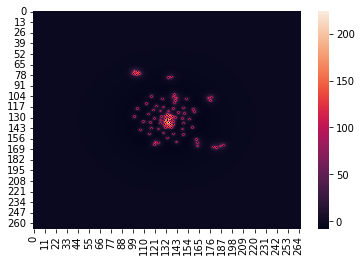

In [120]:
coords, gameboard = make_coords_from_edge_array(edges.to_numpy(), sparsity=200)
coords = layout_coords(coords, gameboard, rounds=2, 
                       r_radius=10, a_radius=10,
                       r_scale=10, a_scale=5
                      )
for node_id, node in coords.items():
    gameboard[node["x"], node["y"]]=0
show_field(gameboard)
#print(coords)

In [71]:
test_add_field_speed(3001,  31, rounds=10000, target_x=5, target_y=5, dtype=np.int32)
#test_add_field_positions()
#test_add_field(31,300)

elapsed time =  0.33082301799731795  rate =  3.30823017997318e-05


## layout an NDEx network and save the result 
- get the network
- get its edges as an array
- make the coordinates
- do the layout
- make a cx layout from the new coordinates
- set it as the layout of the test network
- upload to NDEx


In [16]:
# This is used to prompt users for NDEx credentials in this notebook
#import getpass

In [25]:
# Watch out for typos and be sure to hit enter in the field to set the value!!!
#NDEXUSER = getpass.getpass()
NDEXUSER = "dexterpratt"

In [26]:
# Watch out for typos and be sure to hit enter in the field to set the value!!!
# NDEXPASSWORD = getpass.getpass()
NDEXPASSWORD = "cytoscaperules"
SERVER = "http://www.ndexbio.org"

## get the network and the edges

In [123]:
nci_pid_tcr_signaling_uuid = "0c2862fa-6196-11e5-8ac5-06603eb7f303"
sonic_hedgehog_uuid = "cfd3528f-a7a4-11eb-9e72-0ac135e8bacf"
nest_uuid = "60112105-f853-11e9-bb65-0ac135e8bacf"
string_hc_uuid = "275bd84e-3d18-11e8-a935-0ac135e8bacf"
cptac_genomic_instability_uuid = "d121e661-4cfc-11e9-9f06-0ac135e8bacf"

test_uuid = cptac_genomic_instability_uuid
test_network = ndex2.create_nice_cx_from_server(SERVER, uuid=test_uuid, )
test_network.print_summary()


Name: Genome instability and mutation
Nodes: 1043
Edges: 1376
Node Attributes: 7144
Edge Attributes: 6140



In [124]:
edge_url = SERVER+'/v3/networks/'+test_uuid+'/export?type=edge'
print(edge_url)
r = requests.get(edge_url)

df = pd.read_csv(io.StringIO(r.text),sep='\t')
df
test_edges = df[["source_id", "target_id"]]
#test_edges

http://www.ndexbio.org/v3/networks/d121e661-4cfc-11e9-9f06-0ac135e8bacf/export?type=edge


layout time =  18.91745035900385


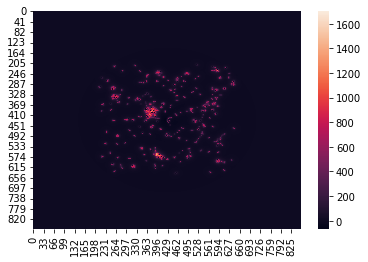

In [125]:
coords, gameboard = make_coords_from_edge_array(test_edges.to_numpy(), sparsity=200)
coords = layout_coords(coords, gameboard, rounds=10, 
                       r_radius=100, a_radius=100,
                       r_scale=5, a_scale=50
                      )
for node_id, node in coords.items():
    gameboard[node["x"], node["y"]]=0
show_field(gameboard)

In [126]:
new_cx_layout = cx_layout_from_coords(coords)
test_network.set_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT, new_cx_layout)
new_network_url = test_network.upload_to(SERVER, NDEXUSER, NDEXPASSWORD)
new_network_uuid = new_network_url.split('/')[-1]
print("Network's URL (click to view!): " + SERVER + "/viewer/networks/" + new_network_uuid)

Generating CX
Network's URL (click to view!): http://www.ndexbio.org/viewer/networks/b5a99d02-2c6a-11ec-b3be-0ac135e8bacf
